In [1]:
import os
import cv2

DOSSIER_EVALUATION = "dataset_test/"
FICHIER_NOMS_CLASS = DOSSIER_EVALUATION + "classes.txt"

# lire les class dans classes.txt
classes = []
fichier_noms_class = open(FICHIER_NOMS_CLASS, "r")
while True:
     line = fichier_noms_class.readline()
     if not line: 
          break
     classes.append(line.strip()) # lire sans '\n'

g_vrai_objets_total = 0

types_evaluations = []
img_buffer = []
img_annotation = []
evaluations_nombre_vrai_objet = [] # contient nombre de vrai objet pour chaque evaluation

# format de nom d'image: <type>_<nombre>.png/jpg/jpeg
# check image a un fichier d'annotation ".txt" sur la format YOLO
for fichier in os.listdir(DOSSIER_EVALUATION):
     
     # n'autoriser que les images
     string_couper = fichier.split('.') 
     extension = string_couper[1]
     if extension != "png" and extension != "jpg" and extension != "jpeg" and extension != "bmp": 
          continue
     
     # vérifier le type d'évaluation, ajouter si n'existe pas
     current_evaluation_index = -1
     nom_evaluation = string_couper[0].split('_')[0]
     evaluation_trouver = False
     for type_index, type in enumerate(types_evaluations):
          current_evaluation_index = type_index
          if(type == nom_evaluation):
               evaluation_trouver = True
               break

     if not evaluation_trouver:
          types_evaluations.append(nom_evaluation)
          img_buffer.append([])
          img_annotation.append([])
          evaluations_nombre_vrai_objet.append(0)
          current_evaluation_index += 1
     
     # lire l'image
     #img_buffer[current_evaluation_index].append([])
     img = cv2.imread(DOSSIER_EVALUATION + fichier)
     hauteur, largeur,_ = img.shape
     img_buffer[current_evaluation_index].append(img)
     
     
     # lire le fichier d'annotation 
     img_annotation[current_evaluation_index].append([])
     fichier_annotation = open(DOSSIER_EVALUATION + string_couper[0] + ".txt", "r")
     while True:
          line = fichier_annotation.readline().strip()
          if not line:
               break
          # decoder YOLO format
          data = line.split(' ')
          data[0] = int(data[0])
          data[1] = float(data[1]) * largeur
          data[2] = float(data[2]) * hauteur
          data[3] = float(data[3]) * largeur 
          data[4] = float(data[4]) * hauteur

          # faire le point en haut à gauche au lieu du centre
          data[1] -= data[3] / 2
          data[2] -= data[4] / 2

          img_annotation[current_evaluation_index][-1].append(data)
          evaluations_nombre_vrai_objet[current_evaluation_index] += 1
          g_vrai_objets_total += 1

# résumé des données de test
print("Types d'évaluation chargés:")
for id, evaluation in enumerate(types_evaluations):
     print("• '" + evaluation + "' - Nombre des images: " + str(len(img_annotation[id])))

print("Total de vrai objets: " + str(g_vrai_objets_total))

# Fonctions utilitaires
def IntersectionSurUnion(x1, y1, largeur1, hauteur1, \
                         x2, y2, largeur2, hauteur2):

     x1_droit = x1 + largeur1
     y1_droit = y1 + hauteur1

     x2_droit = x2 + largeur2
     y2_droit = y2 + hauteur2

     dx = min(x1_droit, x2_droit) - max(x1, x2)
     dy = min(y1_droit, y2_droit) - max(y1, y2)

     # vérifier s'ils se croisent
     if dx <= 0 or dy <= 0:
          return 0

     # surface de chevauchement
     surface_chevauchement = dx * dy

     # surface d'union
     surface_union = ( (largeur1 * hauteur1) + (largeur2 * hauteur2) - surface_chevauchement )

     return surface_chevauchement / surface_union



Types d'évaluation chargés:
• 'couleur' - Nombre des images: 4
• 'db' - Nombre des images: 3
• 'font' - Nombre des images: 3
• 'https' - Nombre des images: 4
• 'manuscript' - Nombre des images: 1
• 'rotation' - Nombre des images: 3
Total de vrai objets: 80


In [2]:
# TP: IoU >= THR
# FP: IoU < THR && Incorrect detection
# Précision : TP / (TP + FP) = TP / Tous les prediction
# Rappel: TP / (TP + FN) = TP / Tous les vrai objets
# Tous les prediction: retourné par le model
# Tous les vrai objets: nombre des annotation dans un image
# Il rest TP utilisant le seuillage ou IoU >= SEUIL

IOU_SEUIL = 0.5

# Précision x Rappel courbe
CONF_SEUIL_MAX = 0.8
CONF_SEUIL_MIN = 0
CONF_NOMBRE_PAS = 11
CONF_PAS = (CONF_SEUIL_MAX -  CONF_SEUIL_MIN) / CONF_NOMBRE_PAS

# Précision moyenne utilisant une interpolation de 11 points
def PrecisionMoyenne(list_rappels, list_precision):
     somme = 0

     point = 0
     while point <= 1:
          max = 0
          for id_rappel, rappel in enumerate(list_rappels):
               precision = list_precision[id_rappel]
               if rappel > point and precision > max:
                    max = precision
          somme += max
          point += 0.1

     return somme / 11

%matplotlib inline
import matplotlib.pyplot as plt

def DessinerCourbePrecisionRappel(list_rappels, list_precisions, nom_evaluation, iou_seuil, dossier_sortie):
     list_rappels.append(1)
     list_precisions.append(0)

     precision_moyenne = (PrecisionMoyenne(list_rappels, list_precisions)) * 100
     precision_moyenne = round(precision_moyenne, 2)

     fig, ax = plt.subplots()
     ax.plot(list_rappels, list_precisions, color="blue")

     ax.set_title("Courbe Précision-Rappel - " + nom_evaluation + " - IOU:" + str(iou_seuil) + "\n Précision Moyenne (AP): " + str(precision_moyenne) + "%" )
     ax.set_ylabel("Précision")
     ax.set_xlabel("Rappel")

     plt.savefig( dossier_sortie + "pr_" + nom_evaluation + ".png", dpi=800)
     plt.show()



In [ ]:
# YOLOv5
import torch

DIMENSIONS_ENTREE = 640

DOSSIER_SORTIE = "predictions/yolov5/"
FICHIER_POIDS = "weights/yolov5_best.pt"

yolov5 = torch.hub.load('ultralytics/yolov5', 'custom', path=FICHIER_POIDS)

global_pr_courbe = [ [], []] # courbe global de model 
evaluations_pr_courbes = [] # liste des courbe pour chaque evaluation 
for eve_id in range(len(types_evaluations)):
     evaluations_pr_courbes.append([[],[]])

conf_seuil_current = CONF_SEUIL_MAX
while conf_seuil_current >= CONF_SEUIL_MIN:
     print("\nPour Seuils: IoU: " + str(IOU_SEUIL) + " - Confedence: " + str(conf_seuil_current) )
     yolov5.conf = conf_seuil_current
     conf_seuil_current -= CONF_PAS

     g_tp = 0
     g_prediction_total = 0

     for eve_id, evaluation in enumerate(types_evaluations):
          eve_tp = 0
          eve_prediction_total = 0
          eve_vrai_objets = evaluations_nombre_vrai_objet[eve_id]

          # prepare l'image: RGB, 640x640
          for img_id, img in enumerate(img_buffer[eve_id]):
               input = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
               input = cv2.resize(input, (DIMENSIONS_ENTREE, DIMENSIONS_ENTREE), interpolation = cv2.INTER_AREA)

               prediction = yolov5([input])
               detections = prediction.xyxy[0].detach().cpu().numpy()

               hauteur, largeur,_ = img.shape
               echelle_largeur = DIMENSIONS_ENTREE / largeur 
               echelle_hateur = DIMENSIONS_ENTREE / hauteur

               # d: [ xmin, ymin, xmax, ymax, confd, class ]
               for d in detections:
                    g_prediction_total += 1
                    eve_prediction_total += 1

                    # a: [ class, xmin, ymin, largeur, hatueur ]
                    for a in img_annotation[eve_id][img_id]:
                         detection_largeur = d[2] - d[0]
                         detection_hateur = d[3] - d[1]

                         # dimension à l'échelle 640x640
                         vrai_x = a[1] * echelle_largeur
                         vrai_y = a[2] * echelle_hateur
                         vrai_largeur = a[3] * echelle_largeur
                         vrai_hauteur = a[4] * echelle_hateur

                         iou_score = IntersectionSurUnion(d[0], d[1], detection_largeur, detection_hateur, 
                                                            vrai_x, vrai_y, vrai_largeur, vrai_hauteur)
     
                         # IoU >= seuil et class correct
                         if iou_score >= IOU_SEUIL and d[5] == a[0]:
                              g_tp += 1
                              eve_tp += 1

               # Dessinez des boîtes, basculez les canaux de couleur vers BGR puis écrivez sur le disque
               result = prediction.render()[0]
               result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
               cv2.imwrite(DOSSIER_SORTIE + types_evaluations[eve_id] + "_" + str(img_id) + ".PNG", result)

          # Calculate Precision et rappel pour l'evaluation current
          eve_precision = (eve_tp / eve_prediction_total) if eve_prediction_total != 0 else 0
          eve_rappel =  eve_tp / eve_vrai_objets

          evaluations_pr_courbes[eve_id][0].append(eve_rappel)
          evaluations_pr_courbes[eve_id][1].append(eve_precision)

          print("• '" + types_evaluations[eve_id] + "' => Précision: " + str(eve_precision) + " - Rappel: " + str(eve_rappel))

     # Global
     g_precision = (g_tp / g_prediction_total) if g_prediction_total != 0 else 0
     g_rappel =  g_tp / g_vrai_objets_total

     global_pr_courbe[0].append(g_rappel)
     global_pr_courbe[1].append(g_precision)

     print("# Global => Précision: " + str(eve_precision) + " - Rappel: " + str(eve_rappel))


# Courbe global
print("Dessiner la courbe Précision-Rappel et calculer la précision moyenne...")
DessinerCourbePrecisionRappel(global_pr_courbe[0], global_pr_courbe[1], "Global", IOU_SEUIL, DOSSIER_SORTIE)

# Courbe pour chaque type d'evaluation
for eve_id, nom_eve in enumerate(types_evaluations):
     DessinerCourbePrecisionRappel( evaluations_pr_courbes[eve_id][0], evaluations_pr_courbes[eve_id][1], nom_eve, IOU_SEUIL, DOSSIER_SORTIE)

In [ ]:
# YOLOv4
import numpy as np

DOSSIER_SORTIE = "predictions/yolov4/"

# en raison des limites du fichier dans Github, le poids YOLOv4 est téléchargeable depuis Google Drive:
# https://drive.google.com/file/d/1-BhVjp-AaIMeWKC0veV_WWac2zYzX4Ye/view?usp=sharing
FICHIER_POIDS = "weights/yolov4_best.weights"
FICHIER_CFG = "weights/yolov4.cfg"

DIMENSIONS_ENTREE = 608

yolov4 = cv2.dnn.readNet(FICHIER_POIDS, FICHIER_CFG)
global_pr_courbe = [ [], []] # courbe global de model 
evaluations_pr_courbes = [] # liste des courbe pour chaque evaluation 
for eve_id in range(len(types_evaluations)):
     evaluations_pr_courbes.append([[],[]])

conf_seuil_current = CONF_SEUIL_MAX
while conf_seuil_current >= CONF_SEUIL_MIN:
     print("\nPour Seuils: IoU: " + str(IOU_SEUIL) + " - Confedence: " + str(conf_seuil_current) )
     conf_seuil_current -= CONF_PAS

     g_tp = 0
     g_prediction_total = 0

     for eve_id, evaluation in enumerate(types_evaluations):
          eve_tp = 0
          eve_prediction_total = 0
          eve_vrai_objets = evaluations_nombre_vrai_objet[eve_id]

          # prepare l'image: RGB 416x416
          for img_id, img in enumerate(img_buffer[eve_id]):
               hauteur, largeur,_ = img.shape

               blob = cv2.dnn.blobFromImage(img, 1/255, (DIMENSIONS_ENTREE, DIMENSIONS_ENTREE), (0,0,0), swapRB=True, crop=False)
               yolov4.setInput(blob)
               output_layers_names = yolov4.getUnconnectedOutLayersNames()
               layerOutputs = yolov4.forward(output_layers_names)

               boxes = []
               confidences = []
               class_ids = []

               for output in layerOutputs:
                   for detection in output:
                       scores = detection[5:]
                       class_id = np.argmax(scores)
                       confidence = scores[class_id]
                       if confidence >= conf_seuil_current:
                           center_x = int(detection[0] * largeur)
                           center_y = int(detection[1]* hauteur)
                           w = int(detection[2]* largeur)
                           h = int(detection[3]* hauteur)
                           x = int(center_x - w/2)
                           y = int(center_y - h/2)

                           boxes.append([x, y, w, h])
                           confidences.append((float(confidence)))
                           class_ids.append(class_id)

               indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)
               output_img = img.copy()
               
               if len(indexes)>0:
                    for i in indexes.flatten():
                         g_prediction_total += 1
                         eve_prediction_total += 1

                         x, y, w, h = boxes[i]
                         label = str(classes[class_ids[i]])
                         confidence = str(round(confidences[i],2))

                         cv2.rectangle(output_img, (x,y), (x+w, y+h), (255,0,0), 2)
                         cv2.putText(output_img, label + " " + confidence, (x, y+20), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255), 2)

                         for a in img_annotation[eve_id][img_id]:
                              vrai_x = a[1]  
                              vrai_y = a[2] 
                              vrai_largeur = a[3]  
                              vrai_hauteur = a[4]  

                              iou_score = IntersectionSurUnion(x, y, w, h, 
                                                                 a[1], a[2], a[3], a[4])

                              # IoU >= seuil et class correct
                              if iou_score >= IOU_SEUIL and class_ids[i] == a[0]:
                                   g_tp += 1
                                   eve_tp += 1

               # ecrivez dans le diskoutput_
               cv2.imwrite(DOSSIER_SORTIE + types_evaluations[eve_id] + "_" + str(img_id) + ".PNG", output_img)

          # Calculate Precision et rappel pour l'evaluation current
          eve_precision = (eve_tp / eve_prediction_total) if eve_prediction_total != 0 else 0
          eve_rappel =  eve_tp / eve_vrai_objets

          evaluations_pr_courbes[eve_id][0].append(eve_rappel)
          evaluations_pr_courbes[eve_id][1].append(eve_precision)

          print("• '" + types_evaluations[eve_id] + "' => Précision: " + str(eve_precision) + " - Rappel: " + str(eve_rappel))
    
     # Global
     g_precision = (g_tp / g_prediction_total) if g_prediction_total != 0 else 0
     g_rappel =  g_tp / g_vrai_objets_total

     global_pr_courbe[0].append(g_rappel)
     global_pr_courbe[1].append(g_precision)
     
     print("# Global => Précision: " + str(eve_precision) + " - Rappel: " + str(eve_rappel))

# Courbe global
print("Dessiner la courbe Précision-Rappel et calculer la précision moyenne...")
DessinerCourbePrecisionRappel(global_pr_courbe[0], global_pr_courbe[1], "Global", IOU_SEUIL, DOSSIER_SORTIE)

# Courbe pour chaque type d'evaluation
for eve_id, nom_eve in enumerate(types_evaluations):
     DessinerCourbePrecisionRappel( evaluations_pr_courbes[eve_id][0], evaluations_pr_courbes[eve_id][1], nom_eve, IOU_SEUIL, DOSSIER_SORTIE)


Pour Seuils: IoU: 0.5 - Confedence: 0.8
• 'couleur' => Précision: 0.8333333333333334 - Rappel: 0.3333333333333333
• 'db' => Précision: 1.0 - Rappel: 0.8888888888888888
• 'font' => Précision: 1.0 - Rappel: 0.5833333333333334
• 'https' => Précision: 0.5 - Rappel: 0.0625
• 'manuscript' => Précision: 0 - Rappel: 0.0
• 'rotation' => Précision: 1.0 - Rappel: 0.08333333333333333
# Global => Précision: 1.0 - Rappel: 0.08333333333333333

Pour Seuils: IoU: 0.5 - Confedence: 0.7272727272727273
• 'couleur' => Précision: 0.8571428571428571 - Rappel: 0.4
• 'db' => Précision: 1.0 - Rappel: 0.9444444444444444
• 'font' => Précision: 1.0 - Rappel: 0.5833333333333334
• 'https' => Précision: 0.5 - Rappel: 0.0625
• 'manuscript' => Précision: 0 - Rappel: 0.0
• 'rotation' => Précision: 1.0 - Rappel: 0.08333333333333333
# Global => Précision: 1.0 - Rappel: 0.08333333333333333

Pour Seuils: IoU: 0.5 - Confedence: 0.6545454545454545
• 'couleur' => Précision: 0.8571428571428571 - Rappel: 0.4
• 'db' => Précision

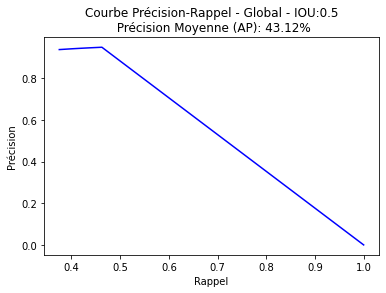

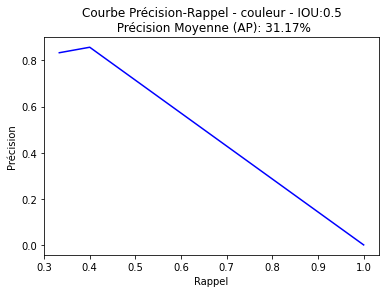

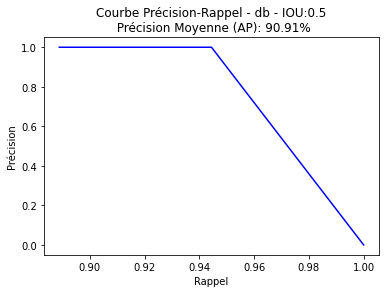

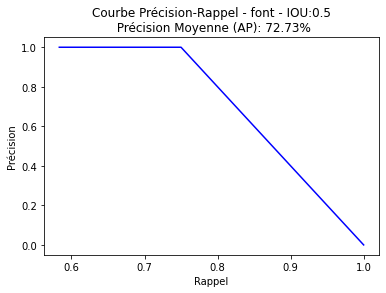

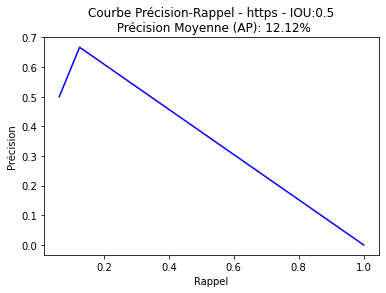

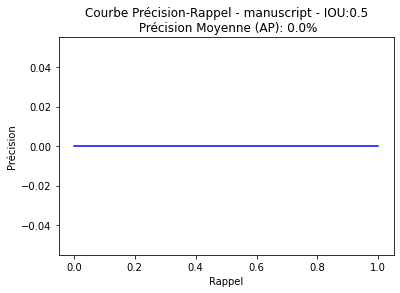

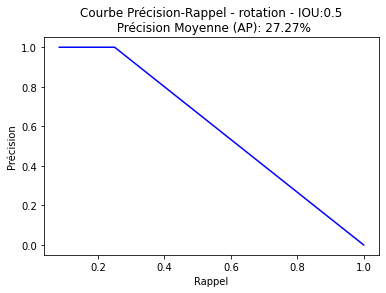

In [5]:
# YOLOv3
import numpy as np

DOSSIER_SORTIE = "predictions/yolov3/"

# en raison des limites du fichier dans Github, le poids YOLOv4 est téléchargeable depuis Google Drive:
# https://drive.google.com/drive/folders/1SkusOM-0fFi_aT8VAhUIiL6j27YnoR7p?usp=sharing
FICHIER_POIDS = "weights/yolov3_training_last.weights"
FICHIER_CFG = "weights/yolov3.cfg"

DIMENSIONS_ENTREE = 416

yolov3 = cv2.dnn.readNet(FICHIER_POIDS, FICHIER_CFG)
global_pr_courbe = [ [], []] # courbe global de model 
evaluations_pr_courbes = [] # liste des courbe pour chaque evaluation 
for eve_id in range(len(types_evaluations)):
     evaluations_pr_courbes.append([[],[]])

conf_seuil_current = CONF_SEUIL_MAX
while conf_seuil_current >= CONF_SEUIL_MIN:
     print("\nPour Seuils: IoU: " + str(IOU_SEUIL) + " - Confedence: " + str(conf_seuil_current) )
     conf_seuil_current -= CONF_PAS

     g_tp = 0
     g_prediction_total = 0

     for eve_id, evaluation in enumerate(types_evaluations):
          eve_tp = 0
          eve_prediction_total = 0
          eve_vrai_objets = evaluations_nombre_vrai_objet[eve_id]

          # prepare l'image: RGB 416x416
          for img_id, img in enumerate(img_buffer[eve_id]):
               hauteur, largeur,_ = img.shape

               blob = cv2.dnn.blobFromImage(img, 1/255, (DIMENSIONS_ENTREE, DIMENSIONS_ENTREE), (0,0,0), swapRB=True, crop=False)
               yolov3.setInput(blob)
               output_layers_names = yolov3.getUnconnectedOutLayersNames()
               layerOutputs = yolov3.forward(output_layers_names)

               boxes = []
               confidences = []
               class_ids = []

               for output in layerOutputs:
                   for detection in output:
                       scores = detection[5:]
                       class_id = np.argmax(scores)
                       confidence = scores[class_id]
                       if confidence >= conf_seuil_current:
                           center_x = int(detection[0] * largeur)
                           center_y = int(detection[1]* hauteur)
                           w = int(detection[2]* largeur)
                           h = int(detection[3]* hauteur)
                           x = int(center_x - w/2)
                           y = int(center_y - h/2)

                           boxes.append([x, y, w, h])
                           confidences.append((float(confidence)))
                           class_ids.append(class_id)

               indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)
               output_img = img.copy()
               
               if len(indexes)>0:
                    for i in indexes.flatten():
                         g_prediction_total += 1
                         eve_prediction_total += 1

                         x, y, w, h = boxes[i]
                         label = str(classes[class_ids[i]])
                         confidence = str(round(confidences[i],2))

                         cv2.rectangle(output_img, (x,y), (x+w, y+h), (255,0,0), 2)
                         cv2.putText(output_img, label + " " + confidence, (x, y+20), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255), 2)

                         for a in img_annotation[eve_id][img_id]:
                              vrai_x = a[1]  
                              vrai_y = a[2] 
                              vrai_largeur = a[3]  
                              vrai_hauteur = a[4]  

                              iou_score = IntersectionSurUnion(x, y, w, h, 
                                                                 a[1], a[2], a[3], a[4])

                              # IoU >= seuil et class correct
                              if iou_score >= IOU_SEUIL and class_ids[i] == a[0]:
                                   g_tp += 1
                                   eve_tp += 1

               # ecrivez dans le diskoutput_
               cv2.imwrite(DOSSIER_SORTIE + types_evaluations[eve_id] + "_" + str(img_id) + ".PNG", output_img)

          # Calculate Precision et rappel pour l'evaluation current
          eve_precision = (eve_tp / eve_prediction_total) if eve_prediction_total != 0 else 0
          eve_rappel =  eve_tp / eve_vrai_objets

          evaluations_pr_courbes[eve_id][0].append(eve_rappel)
          evaluations_pr_courbes[eve_id][1].append(eve_precision)

          print("• '" + types_evaluations[eve_id] + "' => Précision: " + str(eve_precision) + " - Rappel: " + str(eve_rappel))
    
     # Global
     g_precision = (g_tp / g_prediction_total) if g_prediction_total != 0 else 0
     g_rappel =  g_tp / g_vrai_objets_total

     global_pr_courbe[0].append(g_rappel)
     global_pr_courbe[1].append(g_precision)
     
     print("# Global => Précision: " + str(eve_precision) + " - Rappel: " + str(eve_rappel))

# Courbe global
print("Dessiner la courbe Précision-Rappel et calculer la précision moyenne...")
DessinerCourbePrecisionRappel(global_pr_courbe[0], global_pr_courbe[1], "Global", IOU_SEUIL, DOSSIER_SORTIE)

# Courbe pour chaque type d'evaluation
for eve_id, nom_eve in enumerate(types_evaluations):
     DessinerCourbePrecisionRappel( evaluations_pr_courbes[eve_id][0], evaluations_pr_courbes[eve_id][1], nom_eve, IOU_SEUIL, DOSSIER_SORTIE)